# 3D Engine!

Fontes:

- [ ] [Build your own a Ray Tracer](https://avikdas.com/build-your-own-raytracer/)

Okay. Nossa câmera será um vetor, denotado por $\vec{C}$. Mas também precisamos de um plano, que representa a tela, chamado Plano de imagem. Todos os raios serão lançados desse plano, com direção da câmera. Se esse plano é definido pelos vértices $\vec{x}_1, \vec{x}_2, \vec{x}_3, \vec{x}_4$:

$$ \vec{t} = (1 - \alpha)\vec{x}_1 + \alpha\vec{x}_2 $$
$$ \vec{b} = (1 - \alpha)\vec{x}_3 + \alpha\vec{x}_4 $$
$$ \vec{o} = (1 - \beta)\vec{t} + \beta\vec{b} $$

Sendo que $\alpha$ é a porcentagem do píxel em relação a largura da imagem (o $i$-ésimo pixel numa imagem com largura $w$ tem $\alpha = \frac{i}{w}$). O $\beta$ refere-se a altura.

Assim, a direção do raio de cada pixel é

$$ \vec{d} = \vec{o} - \vec{C} $$

In [1]:
import numpy as np

w, h = 512, 196
r  = h/w # ratio
C  = np.array([ 0,  0, -1]) # x, y, z
x1 = np.array([-1,  r,  0]) # top-left
x2 = np.array([ 1,  r,  0]) # top-right
x3 = np.array([-1, -r,  0]) # bottom-left
x4 = np.array([ 1, -r,  0]) # bottom-right

imagePlane = np.zeros((w, h, 2, 3))
for x in range(w):
  alpha = x/w
  t = (1 - alpha) * x1 + alpha * x2
  b = (1 - alpha) * x3 + alpha * x4
  for y in range(h):
    beta = y/h
    o = (1 - beta)*t + beta*b
    # Guarda origem e direção 
    imagePlane[x, y, 0] = o
    imagePlane[x, y, 1] = o - C

del t, b, o, x, r, alpha, beta

Vamos visualizar o que temos até aqui

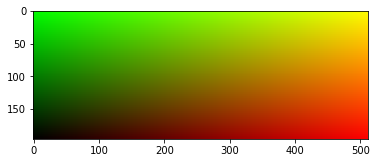

In [17]:
x = imagePlane[:,:,1,0]
y = imagePlane[:,:,1,1]
x = x - np.amin(x) # get length
y = y - np.amin(y) # get length
x = x / np.amax(x) # get percent
y = y / np.amax(y) # get percent

colors = np.zeros((w, h, 3))
colors[:,:,0] = x
colors[:,:,1] = y

del x
del y

from matplotlib.pyplot import imshow
%matplotlib inline

# matplotlib espera hxw
imshow(colors.transpose(1,0,2))

del colors

Yay!  

Raios no topo-esquerdo estão apontando pro topo-esquerdo como deveria ser. Observe que isso é verdade para todos os lados.

---

Estamos prontos pra adicionar esferas no nosso universo.

Todas as esferas precisarão ter pelo menos duas propriedades: posição e raio.

Para cada pixel, precisamos saber se o raio que sai dele intersecta alguma esfera. Ou seja, para cada esfera de raio $r$, centrada em $\vec{s}$, precisamos encontrar $t$ tal que

$$ dist(\vec{o} + \vec{d}t, \vec{s}) = r $$
$$ \Rightarrow \|\vec{o} + \vec{d}t - \vec{s}\| = r$$
$$ \Rightarrow \langle\vec{o} + \vec{d}t - \vec{s}, \vec{o} + \vec{d}t - \vec{s}\rangle = r^2 $$

Pra simplificar fazemos $\vec{s}' = \vec{o} - \vec{s}$:

$$ \langle\vec{s}' + \vec{d}t, \vec{s}' + \vec{d}t\rangle = r^2 $$
$$ = \langle\vec{s}' + \vec{d}t, \vec{s}'\rangle + \langle\vec{s}' + \vec{d}t, \vec{d}t\rangle = r^2 $$
$$ = \langle\vec{s}',\vec{s}'\rangle + \langle\vec{d}t,\vec{s}'\rangle + \langle\vec{s}',\vec{d}t\rangle + \langle\vec{d}t,\vec{d}t\rangle$$
$$ \|\vec{s}'\|^2 + t^2\|\vec{d}\|^2 + 2t\langle\vec{s}',\vec{d}\rangle $$

$$ \Rightarrow \|\vec{d}\|^2t^2 + 2\langle\vec{s}',\vec{d}\rangle t + (\|\vec{s}'\|^2 - r^2) = 0 $$

Para cada esfera, resolvemos a equação do segundo grau e escolhemos a menor solução (o ponto mais próximo). Se não houver solucão, o raio não intersecta uma esfera.

In [18]:
from math import sqrt
def quadraticSolution(a,b,c):
  delta = b*b - 4*a*c
  if delta < 0:
    return None
  if delta == 0:
    return -b/(2*a)
  delta = sqrt(delta)
  t1 = (-b + delta)/(2*a)
  t2 = (-b - delta)/(2*a)
  
  return min(t1, t2)

assert quadraticSolution(3,-7,4) == 1
assert quadraticSolution(9,-12,4) == 2/3
assert quadraticSolution(5,3,5) is None

In [19]:
spheres = np.array([
  # raio, xyz, rgb
  ( 2, ( 0,  2, 10), (1.,0.,0.)),
  (.6, (-1, .5,  2), (0.,1.,0.)),
  ( 5, (-1, -1, 15), (0.,0.,1.))
])

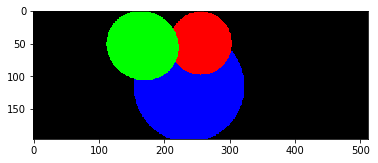

In [20]:
from numpy.linalg import norm

pixels = np.zeros((w,h,3))
for x in range(w):
  for y in range(h):
    o,d = imagePlane[x,y]
    a = norm(d)**2
    smallT = None
    color = None
    for sphere in spheres:
      r = sphere[0]
      s = o - sphere[1] # s'
      b = 2*np.dot(s,d)
      c = norm(s)**2 - r*r
      t = quadraticSolution(a,b,c)
      if t is not None:
        if smallT is None or t < smallT:
          smallT = t
          color = sphere[2]
    if color is not None:
      pixels[x,y] = color

# matplotlib espera hxw
imshow(pixels.transpose(1,0,2))

# clean
del pixels, x, y, o, d, a, smallT
del color, r, s, b, c, t

Yay!

Agora já podemos ver o que a câmera vê. Experimente alterar a posição de $\vec{C}$ e observe como isso altera a visão da câmera!

---

So far, so good.

Agora queremos adicionar profundidade às esferas. Para isso, vamos usar o modelo de iluminação de Phog.

O modelo de Phong possui três componentes básicos:

###### Luz de ambiente

A luz de ambiente emitirá luz com uma intensidade $i_a$. Os objetos no universo refletirão parte ($k_a$) dessa luz, resultando em num reflexo de intensidade $k_ai_a$.

###### Difusão

Para cada luz no cenário, os objetos refletirão uma parte ($k_d$) da itensidade $i_d$ dessa luz. A reflexão será em todas as direções.

A quantidade de luz refletida depende de como a luz acerta o objeto. Se $\vec{L}$ é o vetor da luz, e $\vec{N}$ é o vetor normal ao ponto onde o raio toca, a intensidade da luz difusa é dada por

$$ k_di_d\langle\vec{N},\vec{L}\rangle $$

###### Luz Especular

Para cada luz no cenário, pode existir uma luz especular, que é uma reflexão que depende do ângulo do observador. Se a reflexão vem direto pra câmera, então a intensidade é maior.

Se a luz especular é refletida na direção $\vec{R}$ numa proporção $k_s$, e o objeto tem constante de brilho $\alpha$, e o vetor direção da câmera para o ponto de reflexão é $\vec{V}$, então o resultado é

$$ k_si_s\langle\vec{V},\vec{R}\rangle^\alpha $$

Sendo que
$$ \vec{V} = \frac{\hat{C} - \hat{p}}{\|\hat{C} - \hat{p}\|} $$

E o vetor $\vec{R}$ é coputado da seguinte maneira:

$$ \vec{R} = 2\langle\vec{N}, \vec{L}\rangle\vec{N} - \vec{L} $$

Por último, o vetor normal ao ponto $\hat{p}$ da esfera centrada em $\hat{s}$ é:

$$ \vec{N} = \frac{\hat{p} - \hat{s}}{ \|\hat{p} - \hat{s}\|  } $$

É isto. Vamos criar, em nosso universo, luzes. Cada uma delas precisa ter as seguintes propriedades:

- posição
- intensidade difusa ($i_d$)
- intensidade especular ($i_s$)

Além disso, precisamos adicionar a luz de ambiente $i_a$.

$i_d$, $i_s$ e $i_a$ são, essensialmente, cores.

As esferas, agoram devem ter as seguintes propriedades:

- constante de ambiente $k_a$
- constante de difusão $k_d$
- constante especular $k_s$
- fator de brilho $\alpha$

$k_a$ é, essecialmente, a cor do objeto. As outras constantes são porcentagens de o quanto o material deve refletir em cada um dos canais RGB. $\alpha$ é um escalar.

In [21]:
spheres = np.array([
  # raio,          xyz,         ka,           kd,           ks,   𝛼
  (.5, ( 1.0, -.2, 1.4), (.1,.1,.1), (.9, .2, .2), (.7, .7, .7), 40),
  (.5, ( 0.2,  .1, 1.8), (0.,.4,0.), (.5, .5, .5), (.5, .5, .5), 40),
  (.3, (-1.6, 1.0, 2.5), (0.,0.,.4), (.5, .5, .5), (.5, .5, .5), 40)
])
lights = np.array([
    #       xyz,           id,         is
  ((-2, -.5, 1), (.8, .3, .3), (.8, .8, .8)),
  (( 2,  .5, 0), (.4, .4, .9), (.8, .8, .8))
])
ambientLight = np.array([.5, .5, .5])

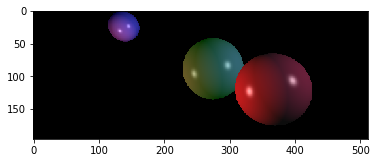

In [22]:
pixels = np.zeros((w,h,3))
for x in range(w):
  for y in range(h):
    o,d = imagePlane[x,y]
    a = norm(d)**2
    smallT = None
    smallS = None
    for sphere in spheres:
      r = sphere[0]
      s = o - sphere[1] # s'
      b = 2*np.dot(s,d)
      c = norm(s)**2 - r*r
      t = quadraticSolution(a,b,c)
      if t is not None:
        if smallT is None or t < smallT:
          smallT = t
          smallS = sphere
    if smallS is not None:
      p = o + d*smallT # ponto de intersecção
      s = smallS[1] # centro da esfera
      N = (p - s) / norm(p - s)
      # vamos calcular a cor
      ka, kd, ks, alpha = smallS[2:]
      V = C - p
      V = V / norm(V)
      color = ambientLight * ka
      for light in lights:
        L = light[0] - p
        L = L / norm(L)
        dot = np.dot(N, L) # luz na direção normal
        if dot < 0:
          # luz está vindo de dentro da esfera!
          continue
        difuse = kd * light[1] * dot
        # agora a luz especular
        R = 2*dot*N - L
        specular = (ks * light[2]) * (np.dot(V, R)**alpha)
        color = color + difuse + specular
        
      color = np.clip(color, 0, 1) # clamp
      pixels[x,y] = color

# matplotlib espera hxw
imshow(pixels.transpose(1,0,2))

# clean
del pixels, x, y, o, d, a, smallT
del smallS, r, s, b, c, t, p, N
del ka, kd, ks, alpha

---

Agora, precisamos de sombras!

A ideia é simples: quando um raio da câmera bater num ponto duma esfera, crie um raio desse ponto para cada ponto de luz. Para cada raio, verifique se ele intersecta um outro objeto do universo. Se intersectar, ignore luz difusa e luz especular vinda desse ponto de luz.

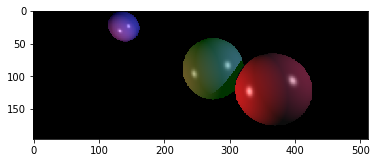

In [23]:
pixels = np.zeros((w,h,3))
for x in range(w):
  for y in range(h):
    o,d = imagePlane[x,y]
    a = norm(d)**2
    smallT = None
    smallS = None
    for sphere in spheres:
      r = sphere[0]
      s = o - sphere[1] # s'
      b = 2*np.dot(s,d)
      c = norm(s)**2 - r*r
      t = quadraticSolution(a,b,c)
      if t is not None:
        if smallT is None or t < smallT:
          smallT = t
          smallS = sphere
    if smallS is not None:
      p = o + d*smallT # ponto de intersecção
      s = smallS[1] # centro da esfera
      N = (p - s) / norm(p - s)
      # vamos calcular a cor
      ka, kd, ks, alpha = smallS[2:]
      V = C - p
      V = V / norm(V)
      color = ambientLight * ka
      for light in lights:
        L = light[0] - p
        L = L / norm(L)
        # verificamos se não há objetos que estão na frente da luz
        shadow = False
        for sphere in spheres:
          if sphere is smallS:
            continue
          # p é a origem
          # L é a direção
          s = p - sphere[1] # s'
          b = 2*np.dot(s,L)
          c = norm(s)**2 - sphere[0]**2
          t = quadraticSolution(a,b,c)
          if t is not None and t > 0 and t < 1:
            shadow = True
            break
        if shadow:
          continue
        # podemos continuar
        dot = np.dot(N, L) # luz na direção normal
        if dot < 0:
          # luz está vindo de dentro da esfera!
          continue
        difuse = kd * light[1] * dot
        # agora a luz especular
        R = 2*dot*N - L
        specular = (ks * light[2]) * (np.dot(V, R)**alpha)
        color = color + difuse + specular
        
      color = np.clip(color, 0, 1) # clamp
      pixels[x,y] = color

# matplotlib espera hxw
imshow(pixels.transpose(1,0,2))

# clean
del pixels, x, y, o, d, a, smallT
del smallS, r, s, b, c, t, p, N
del ka, kd, ks, alpha

E é isto :)

---

Antes de seguirmos em frente, vamos organizar o código em classes e funções, porque será bem útil na hora de criar reflexões:

In [285]:
import numpy as np
from numpy.linalg import norm
from math import pi, tan, atan

class Ray:
  def __init__(self, origin, direction):
    self.origin = np.array(origin)
    self.direction = np.array(direction)
  def at(self, t):
    return self.origin + t*self.direction

class ImagePlane:
  def __init__(self, topLeft, topRight, bottomLeft, bottomRight):
    self.tl = topLeft
    self.tr = topRight
    self.bl = bottomLeft
    self.br = bottomRight

class Camera:
  def __init__(self, f, pos, target=None, up=None, fov=None):
    self.f = f
    self.pos = np.array(pos)
    self.target = target
    self.fov = fov
    
class Sphere:
  def __init__(self, r, xyz, rgb, kd, ks, alpha=40, rug=None):
    self.r = r # raio
    self.xyz = np.array(xyz) # posição
    self.rgb = np.array(rgb) # cor
    #self.ka = ka # fator de reflexão da luz ambiente
    self.kd = np.array(kd) # fator de reflexão difusa
    self.ks = np.array(ks) # fator de reflexão especular (e reflexão)
    self.alpha = alpha # coeficiente de brilho
    self.rug = rug # coeficiente de rugosidade # é alpha?

class Light:
  def __init__(self, xyz, difuse, specular):
    self.xyz = np.array(xyz)
    self.difuse = np.array(difuse)
    self.specular = np.array(specular)
    
class Scene:
  def __init__(self, w, h, camera):
    self.w = w
    self.h = h
    self.camera = camera
    self.bgColor = np.array([0,0,0])
    self.spheres = []
    self.lights = []
    self.ambientLight = np.array([.5, .5, .5])
    self.updateCamera()

  def setCameraDistance(self, distance):
    self.camera.f = distance
    # alterar a distância altera FOV para corresponder
    self.camera.fov = atan(2/distance)
    self.updateCamera()
    
  def setCameraFov(self, fov):
    self.camera.fov = fov
    # aterar FOV altera distância para corresponder
    self.camera.ditance = 2/tan(fov)
    self.updateCamera()
  
  def updateCamera(self):
    camera = self.camera
    distance, fov = camera.f, camera.fov
    if fov is not None:
      distance = 2/tan(fov)
    dist = camera.pos[2] + distance # center of Image Plane
    r = self.h/self.w
    self.iPlane = ImagePlane(
      np.array([-1,  r, dist]), # top left
      np.array([ 1,  r, dist]), # top right
      np.array([-1, -r, dist]), # bottom left
      np.array([ 1, -r, dist])  # bottom right
    )
    
  def setSize(self, w, h):
    self.w = w
    self.h = h
    
  def addSphere(self, sphere):
    self.spheres.append(sphere)
  
  def setSpheres(self, spheres):
    self.spheres = []
    for sphere in spheres:
      self.addSphere(sphere)
  
  def addLight(self, light):
    self.lights.append(light)
    
  def setAmbientLight(self, color):
    self.ambientLight = np.array(color)
  
    
  def rayForPixel(self, x, y):
    xt = x / self.w
    yt = y / self.h
    iPlane = self.iPlane
    
    top = lerp(iPlane.tl, iPlane.tr, xt)
    bottom = lerp(iPlane.bl, iPlane.br, xt)
    point = lerp(top, bottom, yt)
    
    return Ray(point, point - self.camera.pos)
  
  def intersectRay(self, ray, shadowOf=None):
    a = norm(ray.direction)**2
    smallest = None
    for sphere in self.spheres:
      s = ray.origin - sphere.xyz # s'
      b = 2*np.dot(s, ray.direction)
      c = norm(s)**2 - sphere.r**2
      t = quadraticSolution(a,b,c)
      if t is not None and (smallest is None or t < smallest[0]):
        if shadowOf is None:
          smallest = (t, sphere)
        elif shadowOf is not sphere and t > 0 and t < 1:
          return (t, sphere)
    return smallest
  
  def colorForRay(self, ray):
    intersected = self.intersectRay(ray)
    if intersected is None:
      return self.bgColor
    t, sphere = intersected
    intersection = ray.at(t)
    normal = normalize(intersection - sphere.xyz)
    eyeDirection = normalize(self.camera.pos - intersection)
    color = sphere.rgb * self.ambientLight
    for light in self.lights:
      lightDirection = normalize(light.xyz - intersection)
      shadow = self.intersectRay(Ray(intersection, lightDirection), sphere)
      if shadow is not None:
        # está na sombra
        continue
      lightNormal = np.dot(normal, lightDirection)
      if lightNormal < 0:
        continue # luz está vindo por dentro da esfera
      difuse = sphere.kd * light.difuse * lightNormal
      # agora a luz especular
      reflectance = 2*normal*lightNormal - lightDirection
      specular = sphere.ks * light.specular
      specular = specular * np.dot(eyeDirection, reflectance)**sphere.alpha
      color = color + difuse + specular
    return np.clip(color, 0, 1) # clamp
  
  def draw(self, lowQuality=False):
    colors = np.zeros((self.w, self.h, 3))
    if lowQuality:
      for x in range(self.w):
        for y in range(self.h):
          ray = self.rayForPixel(x, y)
          intersection = self.intersectRay(ray)
          colors[x, y] = intersection[1].rgb if intersection is not None else self.bgColor
    else:
      for x in range(self.w):
        for y in range(self.h):
          ray = self.rayForPixel(x, y)
          color = self.colorForRay(ray)
          colors[x, y] = color
    showImage(colors)
  
def normalize(vector):
  return vector / norm(vector)

def lerp(start, end, t):
  return (1 - t)*start + t*end

from math import sqrt
def quadraticSolution(a,b,c):
  delta = b*b - 4*a*c
  if delta < 0:
    return None
  if delta == 0:
    return -b/(2*a)
  delta = sqrt(delta)
  t1 = (-b + delta)/(2*a)
  t2 = (-b - delta)/(2*a)
  
  return min(t1, t2)

from matplotlib.pyplot import imshow
%matplotlib inline
def showImage(image):
  # matplotlib espera hxw
  imshow(image.transpose(1, 0, 2))

In [286]:
def normalizeColor(color):
  color = color - np.amin(color) # get length
  color = color / np.amax(color) # get percent
  return color

def showDirections(scene):
  X = np.zeros((scene.w, scene.h))
  Y = np.zeros((scene.w, scene.h))
  Z = np.zeros((scene.w, scene.h))
  for x in range(scene.w):
    for y in range(scene.h):
      c = scene.rayForPixel(x, y).direction
      X[x, y] = c[0] # red
      Y[x, y] = c[1] # green
#       Z[x, y] = c[2] # blue
  colors = np.zeros((scene.w, scene.h, 3))
  colors[:,:,0] = normalizeColor(X)
  colors[:,:,1] = normalizeColor(Y)
#   colors[:,:,2] = normalizeColor(Z)
  showImage(colors)
  
def createStandardScene(Class=Scene):
  scene = Class(512, 196, Camera(1, np.array([0, 0, -1])))
  scene.addSphere(Sphere(.5, ( 1.0, -.2, 1.4), (.8 ,0., 0.), (.5, .5, .5), (.5, .5, .5)))
  scene.addSphere(Sphere(.5, ( 0.2,  .1, 1.8), (0. ,.8, 0.), (.5, .5, .5), (.5, .5, .5)))
  scene.addSphere(Sphere(.3, (-1.6, 1.0, 2.5), (0. ,0., .8), (.5, .5, .5), (.5, .5, .5)))

  scene.addLight(Light((-20, -.5, 1), (.8, .8, .8), (.8, .8, .8)))
  scene.addLight(Light(( 20,  .5, 0), (.8, .8, .8), (.8, .8, .8)))
  return scene

In [287]:
scene = createStandardScene()

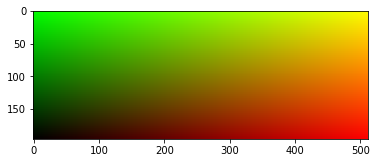

In [288]:
showDirections(scene)

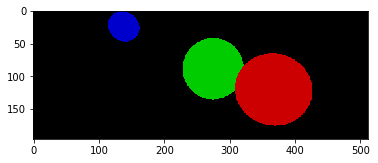

In [289]:
scene.draw(True)

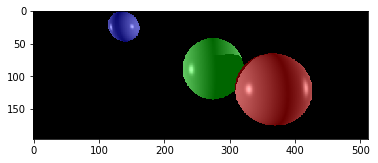

In [290]:
scene.draw()

---

Agora, para as reflexões.

Ao contrário de materiais difusos, materiais reflexivos enviam toda a luz refletida em uma única direção.

O cálculo é similar ao cálculo da luz especular em Phong, com a diferença de que

$$ \vec{R} = 2\langle\vec{N},\vec{V}\rangle\vec{N} - \vec{V} $$

Para encontrar o que será refletido, lançamos um raio a partir do ponto visto na direção $\vec{R}$

In [ ]:
class SceneWithReflections(Scene):
  def colorForRay(self, ray, depth=3):
    intersected = self.intersectRay(ray)
    if intersected is None:
      return self.bgColor
    t, sphere = intersected
    intersection = ray.at(t)
    normal = normalize(intersection - sphere.xyz)
    eyeDirection = normalize(self.camera.pos - intersection)
    color = sphere.rgb * self.ambientLight
    for light in self.lights:
      lightDirection = normalize(light.xyz - intersection)
      shadow = self.intersectRay(Ray(intersection, lightDirection), sphere)
      if shadow is not None:
        # está na sombra
        continue
      lightNormal = np.dot(normal, lightDirection)
      if lightNormal < 0:
        continue # luz está vindo por dentro da esfera
      difuse = sphere.kd * light.difuse * lightNormal
      # agora a luz especular
      reflectance = 2*normal*lightNormal - lightDirection
      specular = sphere.ks * light.specular
      specular = specular * np.dot(eyeDirection, reflectance)**sphere.alpha
      color = color + difuse + specular
    # nesse momento, podemos calcular reflexões
    if depth > 0:
      rd = normalize(-1*ray.direction) # reflection direction
      reflectance = 2*normal*np.dot(normal, rd) - rd
      reflectionRay = Ray(
        intersection + normal*0.01,
        -reflectance
      )
      reflected = self.colorForRay(reflectionRay, depth-1)
      color = color + reflected * sphere.ks
    
    return np.clip(color, 0, 1) # clamp

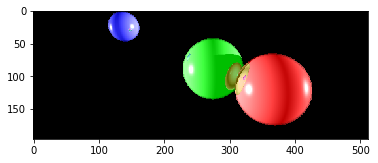

In [ ]:
createStandardScene(SceneWithReflections).draw()

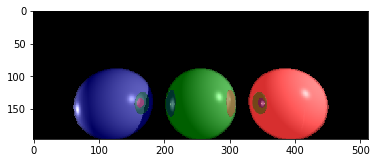

In [ ]:
scene = SceneWithReflections(512, 196, Camera(1, np.array([0, 0, -1])))
scene.addSphere(Sphere(.5, ( 1.2, -.4, 1.4), (.9 ,.2, .2), (.5, .5, .5), (.5, .5, .5)))
scene.addSphere(Sphere(.5, ( 0.0, -.4, 1.4), (0. ,.4, 0.), (.5, .5, .5), (.5, .5, .5)))
scene.addSphere(Sphere(.5, (-1.2, -.4, 1.4), (0. ,0., .4), (.5, .5, .5), (.5, .5, .5)))

scene.addLight(Light((-2, -.5, 1), (.8, .8, .8), (.8, .8, .8)))
scene.addLight(Light(( 2,  .5, 0), (.4, .4, .4), (.4, .4, .4)))

scene.draw()

---

Agora podemos fazer uns testes (:

In [ ]:
gray = (0.5, 0.5, 0.5)
scene.setCameraDistance(.7)
scene.addSphere(Sphere(2, (0, 2, 1.8), gray, gray, gray))
scene.draw()

In [ ]:
scene.setCameraFov(pi/4)

In [ ]:
scene.draw(True)